Question 4 part a

In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import StandardScaler

# Create a Spark session
spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

# loading the data
#data = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/annbiju7@gmail.com/Housing-1.csv")
data = spark.read.option("header", "true").option("inferSchema", "true").csv("/FileStore/tables/Housing.csv")

#display(data)

#part a

# remove categorical features
selected_cols = [col for col in data.columns if col not in ["mainroad",
                                                            "guestroom",
                                                            "basement",
                                                            "hotwaterheating",
                                                            "airconditioning",
                                                            "prefarea",
                                                            "furnishingstatus"]]
df = data.select(selected_cols)

# Create a feature vector for K-means
feature_cols = [col for col in df.columns if col != "furnishingstatus"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

scaled_df.cache()

# Part a: Plot the Silhouette scores for K = 2 to 10 and find the optimal number of clusters
evaluator = ClusteringEvaluator()
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures",
                    predictionCol="prediction")
    model = kmeans.fit(scaled_df)
    predictions = model.transform(scaled_df)
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append((k, silhouette))

# Display Silhouette scores
for k, silhouette in silhouette_scores:
    print(f"Silhouette score for K={k}: {silhouette}")

# Find the optimal K
optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters (K): {optimal_k}")


Silhouette score for K=2: 0.5650004266841395
Silhouette score for K=3: 0.2047124458321516
Silhouette score for K=4: -0.0270393303144507
Silhouette score for K=5: -0.1089266585166245
Silhouette score for K=6: 0.04957318056376036
Silhouette score for K=7: -0.10870522194187535
Silhouette score for K=8: -0.23743969010313615
Silhouette score for K=9: -0.19376929170050167
Silhouette score for K=10: -0.2507708553661496
Optimal number of clusters (K): 2


part b

In [0]:
from pyspark.ml.feature import PCA

# Run K-means clustering method for K = 2 to 10 
pca_kmeans = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures", predictionCol="prediction")
    model = kmeans.fit(scaled_df)
    predictions = model.transform(scaled_df)

    # PCA step
    pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
    pca_model = pca.fit(predictions)
    pca_result = pca_model.transform(predictions).select("pcaFeatures", "prediction")
    pca_kmeans.append((k, pca_result))

# Display PCA clusters
for k, pca_result in pca_kmeans:
    pca_result.show()

+--------------------+----------+
|         pcaFeatures|prediction|
+--------------------+----------+
|[-10.936662058098...|         1|
|[-13.402323807917...|         1|
|[-10.110121959113...|         1|
|[-10.574849701582...|         1|
|[-9.1067570802106...|         1|
|[-9.7241539088330...|         1|
|[-11.509730962053...|         1|
|[-11.760920613523...|         1|
|[-8.7780104328361...|         1|
|[-9.1754091098756...|         1|
|[-9.0934457381723...|         1|
|[-10.087220190571...|         1|
|[-8.8513065393173...|         1|
|[-8.6752766678044...|         1|
|[-8.1508056740753...|         1|
|[-8.1992706655507...|         1|
|[-8.7992214067584...|         1|
|[-9.7622357433830...|         1|
|[-8.2306543903982...|         1|
|[-8.1675146928794...|         1|
+--------------------+----------+
only showing top 20 rows

+--------------------+----------+
|         pcaFeatures|prediction|
+--------------------+----------+
|[-10.936662058098...|         1|
|[-13.402323807917...|

Q4, part c

KMeans_5278baea1739
euclidean
KMeans_ddf42a8c0687
euclidean
KMeans_2e74c12577ad
euclidean
KMeans_0549439f9b05
euclidean
KMeans_3985eb0e69ef
euclidean
KMeans_8bcf17b300ef
euclidean
KMeans_11f88c021210
euclidean
KMeans_53c46dc6880d
euclidean
KMeans_c13b45a1977e
euclidean
WSSSE for K=2: 2338.7528589985814
WSSSE for K=3: 1956.2269857452052
WSSSE for K=4: 1695.2531197975961
WSSSE for K=5: 1518.2228986203206
WSSSE for K=6: 1450.3193373498814
WSSSE for K=7: 1271.9487840634365
WSSSE for K=8: 1247.457223452873
WSSSE for K=9: 1238.9891012552953
WSSSE for K=10: 1129.940404898411


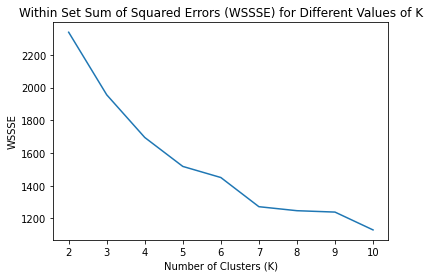

In [0]:
# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse_values = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures", predictionCol="prediction")
    print(kmeans)
    print(kmeans.fit(scaled_df).getDistanceMeasure())
    wssse = kmeans.fit(scaled_df).summary.trainingCost
    wssse_values.append((k, wssse))

# Display WSSSE values
for k, wssse in wssse_values:
    print(f"WSSSE for K={k}: {wssse}")

# Plot and compare the WSSSE values for each K
plt.plot([k for k, _ in wssse_values], [wssse for _, wssse in wssse_values])
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WSSSE")
plt.title("Within Set Sum of Squared Errors (WSSSE) for Different Values of K")
plt.show()

Question 5

In [0]:
#data = sc.textFile("/Filestore/tables/ratings.dat")

from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.mllib.recommendation import MatrixFactorizationModel, Rating

# Create a Spark session
spark = SparkSession.builder.appName("RecommendationSystem").getOrCreate()

# Load the ratings.dat dataset
ratings_df = spark.read.option("inferSchema", "true").option("delimiter", "::").csv("/FileStore/tables/ratings.dat")
ratings_df = ratings_df.withColumnRenamed("_c0", "userId").withColumnRenamed("_c1", "movieId").withColumnRenamed("_c2", "rating").withColumnRenamed("_c3", "timestamp")

# Convert userId and movieId to integers
ratings_df = ratings_df.withColumn("userId", col("userId").cast(IntegerType()))
ratings_df = ratings_df.withColumn("movieId", col("movieId").cast(IntegerType()))

# (70% training, 30% testing)
(training_data, test_data) = ratings_df.randomSplit([0.7, 0.3], seed=42)

# ALS model building
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training_data)

# predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.8294242729268162


Question 6 part a

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import lower

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version", spark.version)

trainDataset = spark.read \
    .option("header", True) \
    .csv("/FileStore/tables/Train.csv", multiLine=True, escape='"')

spark = SparkSession.builder.appName('Class Demo').getOrCreate()

df = spark.read.csv('/FileStore/tables/Train.csv', multiLine=True, escape='"', inferSchema=True, header=True)

#print(df.count())
#display(df)

mytrain = (trainDataset.groupBy("label").count().orderBy(col("count").desc()))

testDataset = spark.read \
    .option("header", True) \
    .csv("/FileStore/tables/Test.csv", multiLine=True, escape='"')

mytest = (trainDataset.groupBy("label").count().orderBy(col("count").desc()))
display(mytrain)
display(mytest)

Spark NLP version 5.1.4
Apache Spark version 3.3.2


label count 0 20019 1 19981

label count 0 20019 1 19981

Q6, part b

In [0]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

document = sparknlp.base.document_assembler.DocumentAssembler().setInputCol("text").setOutputCol("document")

#downloading pretrained embeddings
use = UniversalSentenceEncoder.pretrained().setInputCols(["document"]).setOutputCol("sentence_embeddings")

classiferdl = ClassifierDLApproach().setInputCols(["sentence_embeddings"]).setOutputCol("class").setLabelColumn("label").setMaxEpochs(5).setEnableOutputLogs(True)
use_clf_pipeline = Pipeline(stages = [document, use, classiferdl])
use_piplineModel = use_clf_pipeline.fit(trainDataset)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [0]:
dbutils.fs.ls("dbfs:/root/")

Out[32]: [FileInfo(path='dbfs:/root/annotator_logs/', name='annotator_logs/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/root/cache_pretrained/', name='cache_pretrained/', size=0, modificationTime=0)]

In [0]:
dbutils.fs.ls("dbfs:/root/annotator_logs/")

Out[33]: [FileInfo(path='dbfs:/root/annotator_logs/ClassifierDLApproach_d1b86f443338.log', name='ClassifierDLApproach_d1b86f443338.log', size=442, modificationTime=1701635066000)]

In [0]:
mylog = spark.read.text("dbfs:/root/annotator_logs/ClassifierDLApproach_d1b86f443338.log")

In [0]:
display(mylog)

value Training started - epochs: 5 - learning_rate: 0.005 - batch_size: 64 - training_examples: 40000 - classes: 2 Epoch 0/5 - 11.73s - loss: 290.9983 - acc: 0.83495 - batches: 625 Epoch 1/5 - 10.29s - loss: 277.45578 - acc: 0.8558 - batches: 625 Epoch 2/5 - 10.96s - loss: 274.98056 - acc: 0.86345 - batches: 625 Epoch 3/5 - 9.81s - loss: 273.24802 - acc: 0.867675 - batches: 625 Epoch 4/5 - 10.25s - loss: 271.30856 - acc: 0.87155 - batches: 625

In [0]:
preds = use_piplineModel.transform(testDataset)
mypred = preds.select('label', 'text', 'class.result')
display(mypred)

label text result 0 I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hairy lighthouse foghorn. The women are physically attractive but too Stepford-is to elicit any real feeling from the viewer. There is absolutely no reason to stop yourself from running down to the local TV station with a can of gasoline and a flamethrower and sending every copy of this mutt howling back to hell. Except.. Except for the wonderful comic sty lings of Larry Joe Campbell, America's Greatest Comic Character Actor. This guy plays Belushi's brother-in-law, Andy, and he is gold. How good is he really? Well, aside from being funny, his job is to make Belushi look good. That's like trying to make butt warts look good. But Campbell pulls it off with style. Someone should invent a Nobel Prize in Comic Buffoonery so he can win it every year. Without Larry Joe this show would consist of a slightly vacant looking Courtney Thorne-Smith smacking Belushi over the head with a frying pan while he alternately beats his chest and plays with the straw on the floor of his cage. 5 stars for Larry Joe Campbell designated Comedic Bacon because he improves the flavor of everything he's in! List(1) 0 1st watched 12/7/2002 - 3 out of 10(Dir-Steve Purcell): Typical Mary Kate & Ashley fare with a few more kisses. It looks to me like the girls are getting pretty tired of this stuff and it will be interesting what happens to them if they ever decide to split up and go there own ways. In this episode of their adventures they are interns in Rome for a `fashion' designer who puts them right into the mailroom to learn what working hard is all about(I guess..). Besides the typical flirtations with boys there is nothing much else except the Rome scenario until about ¾ way into the movie when it's finally revealed why they are getting fired, then re-hired, then fired again, then re-hired again. This is definetly made by people who don't understand the corporate world and it shows in their interpretation of it. Maybe the real world will be their next adventure(if there is one.). Even my kids didn't seem to care for this boring `adventure' in the make-believe. Let's see they probably only have a couple of years till their legal adults. We'll see what happens then. List(0) 0 This movie was so poorly written and directed I fell asleep 30 minutes through the movie. The jokes in the movie are corny and even though the plot is interesting at some angles, it is too far fetched and at some points- ridiculous. If you are 11 or older you will overlook the writing in the movie and be disappointed, but if you are 10 or younger this is a film that will capture your attention and be amazed with all the stunts (which I might add are poorly done) and wish you were some warrior to. The casting in this movie wasn't very good, and the music was very disappointing because it was like they were trying to build up the tension but it didn't fit at all. On a scale of 1-10 (10 being excellent, 1 being horrible) the acting in this movie is a 4. Brenda Song is talented in comedy, but with th

part c

In [0]:
from sklearn.metrics import classification_report, accuracy_score

preds_df = preds.select('label', 'text', 'class.result').toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x:x[0])

print(classification_report(preds_df['label'], preds_df['result']))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2495
           1       0.86      0.87      0.86      2505

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

